# Requirements

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings

warnings.filterwarnings('ignore') 
%matplotlib inline

In [0]:
# Global variables
city_and_state_separated = False

In [159]:
# Reading dataset
data = pd.read_csv('/content/drive/My Drive/Airports2.csv')
data.head(5)

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150001
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150001
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150001
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150001


# Exploratory Data Analisys

In [160]:
# Initial shape
data.shape

(3606803, 15)

In [0]:
# Convert to date
data['Fly_date'] = pd.to_datetime(data.Fly_date)
data.sort_values(by='Fly_date', inplace=True)

In [0]:
# Add Quantity_seats
data['Quantity_seats'] = data['Seats'] / data['Flights']

In [0]:
# Separating city and state destination
if city_and_state_separated == False:
  data['Destination_city'], data['Destination_state'] = data['Destination_city'].str.split(',', 1).str
  data['Origin_city'], data['Origin_state'] = data['Origin_city'].str.split(',', 1).str
  data['Destination_state'] = data['Destination_state'].str.strip()
  data['Origin_state'] = data['Origin_state'].str.strip()
  city_and_state_separated = True

In [0]:
# Delete flights = 0
data = data.drop(data[data['Flights'] == 0].index)

In [0]:
# Delete rows that have more than 615 seats per flight, since the plane with the highest passenger capacity = 615
data = data.drop(data[data['Quantity_seats'] > 615].index)

In [0]:
# Delete flights with seats = 0
data = data.drop(data[data['Seats'] == 0].index)

In [0]:
# Delete flights with passengers = 0
data = data.drop(data[data['Passengers'] == 0].index)

In [0]:
# Delete flights with distance = 0
data = data.drop(data[data['Distance'] == 0].index)

In [0]:
# Delete quantity seats < 1
data = data.drop(data[data['Quantity_seats'] < 1].index)

In [170]:
# Maximum values of each column
data.max()

Origin_airport                            YUM
Destination_airport                       YUM
Origin_city                              Yuma
Destination_city                         Yuma
Passengers                              89597
Seats                                  147062
Flights                                  1128
Distance                                 5018
Fly_date                  2009-12-01 00:00:00
Origin_population                    38139592
Destination_population               38139592
Org_airport_lat                       64.8375
Org_airport_long                     -68.8281
Dest_airport_lat                      64.8375
Dest_airport_long                    -68.8281
Quantity_seats                            613
Destination_state                          WY
Origin_state                               WY
dtype: object

In [171]:
# Minimum values of each column
data.min()

Origin_airport                            1B1
Destination_airport                       1B1
Origin_city                          Aberdeen
Destination_city                     Aberdeen
Passengers                                  1
Seats                                       1
Flights                                     1
Distance                                    2
Fly_date                  1990-01-01 00:00:00
Origin_population                       13005
Destination_population                  13005
Org_airport_lat                       19.7214
Org_airport_long                     -157.922
Dest_airport_lat                      19.7214
Dest_airport_long                    -157.922
Quantity_seats                              1
Destination_state                          AK
Origin_state                               AK
dtype: object

In [172]:
# Percentage of null values

# Note: as almost all values are 'valid', with the exception of Destination_population column which has 
# some few null values (0.00003%), so we will not delete any other column. Longitude and latitude are
# only used for visualization.

total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data

,Total,Percent
Org_airport_long,3564,0.001108
Org_airport_lat,3564,0.001108
Dest_airport_long,3496,0.001086
Dest_airport_lat,3496,0.001086
Origin_state,0,0.000000
Flights,0,0.000000
Destination_airport,0,0.000000
Origin_city,0,0.000000
Destination_city,0,0.000000
Passengers,0,0.000000


### **Column description**

**Origin_airport**: Three letter airport code of the origin airport

**Destination_airport**: Three letter airport code of the destination airport

**Origin_city**: Origin city name

**Destination_city**: Destination city name

**Origin_state**: Origin state acronym

**Destination_state**: Destination state acronym

**Passengers**: Number of passengers transported from origin to destination

**Seats**: Number of seats available on flights from origin to destination

**Flights**: Number of flights between origin and destination (multiple records for one month, many with flights > 1)

**Distance**: Distance (to nearest mile) flown between origin and destination

**Fly_date**: The date (yyyymm) of flight

**Origin_population**: Origin city's population as reported by US Census

**Destination_population**: Destination city's population as reported by US Census

**Quantity_seats**: Quantity of seats

# Data Visualisation

In [173]:
# States with most incoming passanger quantity in 2009
import plotly.graph_objects as go

result = data[data['Fly_date'].dt.year == 2009]
result = data.groupby('Destination_state').agg({'Passengers': sum})
result = result.reset_index()

fig = go.Figure(data=go.Choropleth(
    locations=result['Destination_state'],
    z=result['Passengers'],
    locationmode='USA-states',
    colorbar_title='Passengers',
))

fig.update_layout(
    title_text='Most destination States',
    geo_scope='usa',
)

fig.show()

[Text(0.5, 0, 'Month')]

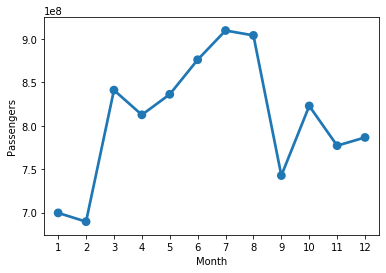

In [174]:
# Best months for airlines based on passenger quantity 
result = data.groupby(data['Fly_date'].dt.month).agg({'Passengers': sum})
result = result.reset_index()
gph = sns.pointplot(x='Fly_date', y='Passengers', data=result)
gph.set(xlabel='Month')

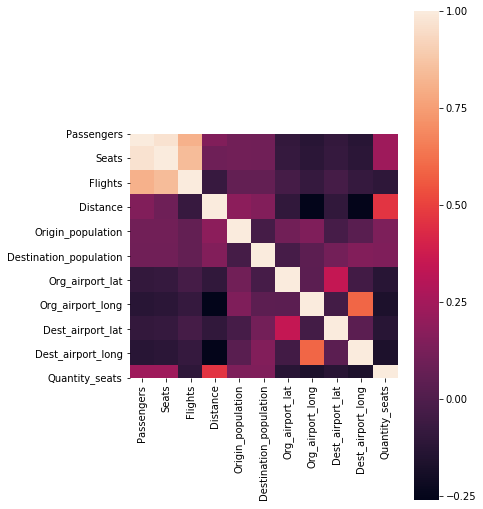

In [175]:
# Corralation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(6, 9))
sns.heatmap(corrmat, vmax=1, square=True);

In [176]:
# Sorted correlation vector over passengers
corrmat = data.corr()
corrmat[['Passengers']].sort_values(by='Passengers', ascending=False).style.background_gradient()

,Passengers
Passengers,1
Seats,0.96846
Flights,0.808151
Quantity_seats,0.235494
Distance,0.150724
Origin_population,0.105528
Destination_population,0.102141
Org_airport_lat,-0.0926801
Dest_airport_lat,-0.0937943
Org_airport_long,-0.125493


According to correlation matrix, we only need 'Passengers', 'Seats' and 'Flights' fields.

In [177]:
df = data[['Passengers', 'Seats', 'Flights']]
df.head(5)

,Passengers,Seats,Flights
730469,1713,4410,30
448453,1476,4619,31
1458454,388,2100,21
448454,1337,3348,31
448455,2787,4888,52


# Normally test

### Passengers Field

In [178]:
df['Passengers'].describe()

count    3.217724e+06
mean     3.013878e+03
std      4.495341e+03
min      1.000000e+00
25%      2.020000e+02
50%      1.542000e+03
75%      3.883000e+03
max      8.959700e+04
Name: Passengers, dtype: float64

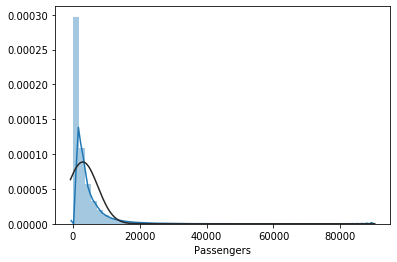

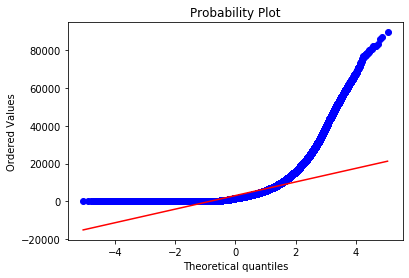

In [179]:
sns.distplot(df['Passengers'], fit=norm)
fig = plt.figure()
res = stats.probplot(df['Passengers'], plot = plt)

In [180]:
# Initial kurtosis and skewness
print('Skewness: %f' % df['Passengers'].skew())
print('Kurtosis: %f' % df['Passengers'].kurt())

Skewness: 3.806619
Kurtosis: 24.555219


In [0]:
df['Passengers'] = np.log(df['Passengers'])

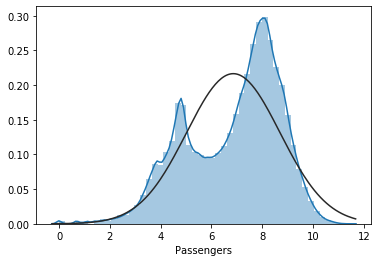

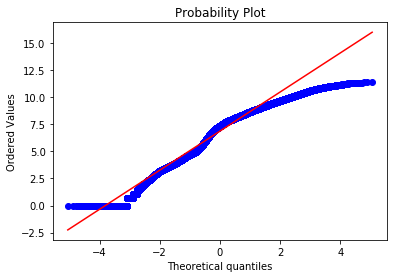

In [182]:
sns.distplot(df['Passengers'], fit=norm)
fig = plt.figure()
res = stats.probplot(df['Passengers'], plot = plt)

In [183]:
# Final kurtosis and skewness
print('Skewness: %f' % df['Passengers'].skew())
print('Kurtosis: %f' % df['Passengers'].kurt())

Skewness: -0.550605
Kurtosis: -0.445288


### Seats Fields

In [184]:
df['Seats'].describe()

count    3.217724e+06
mean     4.534924e+03
std      6.395152e+03
min      1.000000e+00
25%      3.440000e+02
50%      2.780000e+03
75%      5.917000e+03
max      1.470620e+05
Name: Seats, dtype: float64

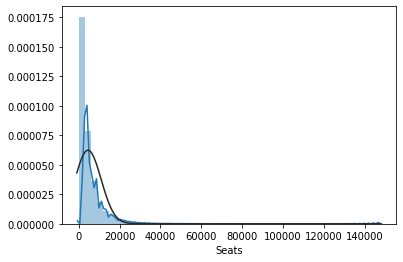

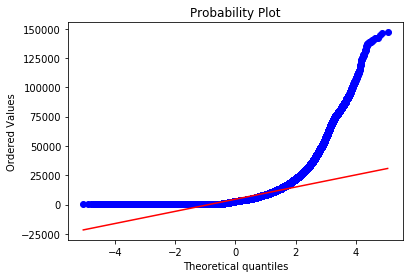

In [185]:
sns.distplot(df['Seats'], fit=norm)
fig = plt.figure()
res = stats.probplot(df['Seats'], plot = plt)

In [186]:
# Initial kurtosis and skewness
print('Skewness: %f' % df['Seats'].skew())
print('Kurtosis: %f' % df['Seats'].kurt())

Skewness: 3.958589
Kurtosis: 29.359281


In [0]:
df['Seats'] = np.log(df['Seats'])

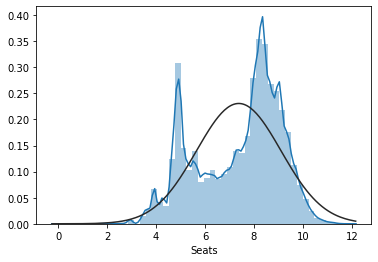

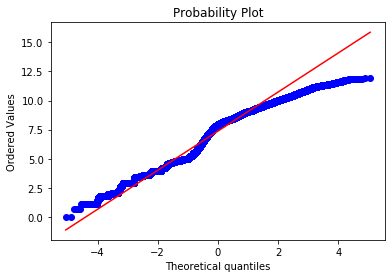

In [188]:
sns.distplot(df['Seats'], fit=norm)
fig = plt.figure()
res = stats.probplot(df['Seats'], plot = plt)

In [189]:
# Final kurtosis and skewness
print('Skewness: %f' % df['Seats'].skew())
print('Kurtosis: %f' % df['Seats'].kurt())

Skewness: -0.463066
Kurtosis: -0.871063


### Flights Field

In [190]:
df['Flights'].describe()

count    3.217724e+06
mean     4.063106e+01
std      5.130158e+01
min      1.000000e+00
25%      3.000000e+00
50%      2.800000e+01
75%      5.800000e+01
max      1.128000e+03
Name: Flights, dtype: float64

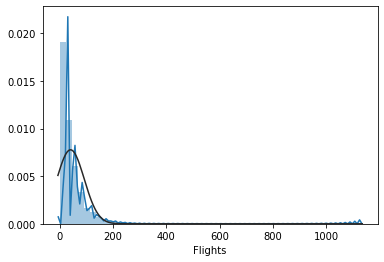

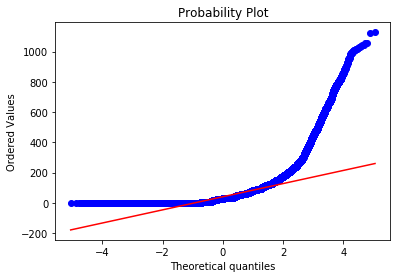

In [191]:
sns.distplot(df['Flights'], fit=norm)
fig = plt.figure()
res = stats.probplot(df['Flights'], plot = plt)

In [192]:
# Initial kurtosis and skewness
print('Skewness: %f' % df['Flights'].skew())
print('Kurtosis: %f' % df['Flights'].kurt())

Skewness: 3.414242
Kurtosis: 24.463164


In [0]:
df['Flights'] = np.log(df['Flights'])

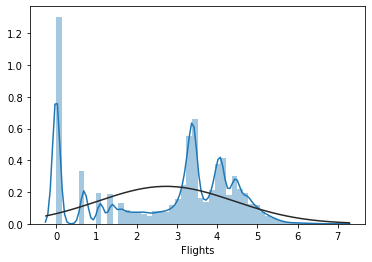

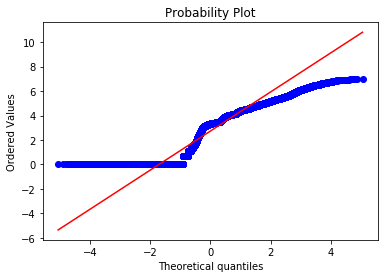

In [194]:
sns.distplot(df['Flights'], fit=norm)
fig = plt.figure()
res = stats.probplot(df['Flights'], plot = plt)

In [195]:
# Final kurtosis and skewness
print('Skewness: %f' % df['Flights'].skew())
print('Kurtosis: %f' % df['Flights'].kurt())

Skewness: -0.476492
Kurtosis: -1.107593


# Machine Learning Models

In [0]:
# Splitting dataset into test and train sets
from sklearn.model_selection import train_test_split

Y = df['Passengers'].values
X = df.drop(labels=['Passengers'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

### Linear Regression

In [197]:
# Training
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [198]:
# Predicting
y_pred = regressor.predict(X_test)
result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result.head(10)

,Actual,Predicted
0,8.904359,8.942728
1,8.986071,9.255362
2,8.359837,8.636616
3,8.156797,7.879562
4,8.334472,8.081926
5,7.901007,7.899350
6,8.528924,8.252882
7,7.154615,6.762207
8,4.418841,5.177008
9,8.217169,7.871686


In [199]:
# Predicting score

print ('Score with test data set: ', regressor.score(X_test, y_test))
print ('Score with train data set: ', regressor.score(X_train, y_train))

Score with test data set:  0.9409696542340975
Score with train data set:  0.9410775145364314


### Decision Tree: Random Forests

In [200]:
# Training
from sklearn.preprocessing import PolynomialFeatures 
  
regressor = PolynomialFeatures(degree=2) 
X_poly_train = regressor.fit_transform(X_train)
  
regressor.fit(X_poly_train, y_train) 
lin2 = LinearRegression() 
lin2.fit(X_poly_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [201]:
X_poly_test = regressor.fit_transform(X_test)
y_pred = lin2.predict(X_poly_test)
result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result.head(10)

,Actual,Predicted
0,8.904359,8.968539
1,8.986071,9.302025
2,8.359837,8.647707
3,8.156797,7.881095
4,8.334472,8.096660
5,7.901007,7.895424
6,8.528924,8.221377
7,7.154615,6.764028
8,4.418841,5.023687
9,8.217169,7.873898


In [202]:
print ('Score with test data set: ', lin2.score(X_poly_test, y_test))
print ('Score with train data set: ', lin2.score(X_poly_train, y_train))

Score with test data set:  0.9416626036835528
Score with train data set:  0.9417910825439932


As you can see the models applied are similar, as we are dealing with a regression. Both, the linear and non linear model have a good score since our exercise is very simple and there are no much fields to evaluate. For this example, we could use both algorithm.